In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import time
from pyod.models.vae import VAE
import torch

dataset_path = "C:/Users/apekx/Desktop/thesis/AIonosphere.npz"  

f = np.load(dataset_path)
x_train = f["x"]
x_test = f["tx"]
y_test = f["ty"]

print("Dataset loaded:")
print(f"Train shape: {x_train.shape}, Test shape: {x_test.shape}, Labels shape: {y_test.shape}")

x_train = np.nan_to_num(x_train, nan=0.0, posinf=1.0, neginf=-1.0)
x_test = np.nan_to_num(x_test, nan=0.0, posinf=1.0, neginf=-1.0)

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

X_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)


Dataset loaded:
Train shape: (99, 32), Test shape: (252, 32), Labels shape: (252,)


#### ß-VAE with pyod

In [2]:
def run_beta_vae(x_train, x_test, y_test, beta=1.0, latent_dim=64):
    print(f"\nTraining β-VAE with beta = {beta}, latent_dim = {latent_dim}")

    vae = VAE(
        contamination=0.1,
        encoder_neuron_list=[128, 64, 32],
        decoder_neuron_list=[32, 64, 128],
        latent_dim=latent_dim,
        epoch_num=100,
        batch_size=32,
        lr=0.001,
        dropout_rate=0.1,
        beta=beta,
        verbose=0
    )

    vae.fit(x_train)
    scores = vae.decision_function(x_test)
    scores = (scores - scores.min()) / (scores.max() - scores.min())

    roc = roc_auc_score(y_test, scores)
    precision, recall, _ = precision_recall_curve(y_test, scores)
    pr = auc(recall, precision)



    print(f"β-VAE (β={beta}) → ROC AUC: {roc:.4f}, PR AUC: {pr:.4f}")

    return {
        "beta": beta,
        "latent_dim": latent_dim,
        "roc_auc": roc,
        "pr_auc": pr,
    }

In [3]:
beta_values = [0.1, 0.5, 1.0, 2.0, 5.0]
latent_dims = [16, 32, 64, 128, 256]

results = []

for latent_dim in latent_dims:
    for beta in beta_values:
        print(f"Training β-VAE with latent_dim={latent_dim}, beta={beta}")
        result = run_beta_vae(x_train_scaled, x_test_scaled, y_test, beta=beta, latent_dim=latent_dim)
        results.append(result)

Training β-VAE with latent_dim=16, beta=0.1

Training β-VAE with beta = 0.1, latent_dim = 16
β-VAE (β=0.1) → ROC AUC: 0.9194, PR AUC: 0.9267
Training β-VAE with latent_dim=16, beta=0.5

Training β-VAE with beta = 0.5, latent_dim = 16
β-VAE (β=0.5) → ROC AUC: 0.9194, PR AUC: 0.9267
Training β-VAE with latent_dim=16, beta=1.0

Training β-VAE with beta = 1.0, latent_dim = 16
β-VAE (β=1.0) → ROC AUC: 0.9194, PR AUC: 0.9267
Training β-VAE with latent_dim=16, beta=2.0

Training β-VAE with beta = 2.0, latent_dim = 16
β-VAE (β=2.0) → ROC AUC: 0.9194, PR AUC: 0.9267
Training β-VAE with latent_dim=16, beta=5.0

Training β-VAE with beta = 5.0, latent_dim = 16
β-VAE (β=5.0) → ROC AUC: 0.9194, PR AUC: 0.9267
Training β-VAE with latent_dim=32, beta=0.1

Training β-VAE with beta = 0.1, latent_dim = 32
β-VAE (β=0.1) → ROC AUC: 0.9179, PR AUC: 0.9254
Training β-VAE with latent_dim=32, beta=0.5

Training β-VAE with beta = 0.5, latent_dim = 32
β-VAE (β=0.5) → ROC AUC: 0.9179, PR AUC: 0.9254
Training β-VA

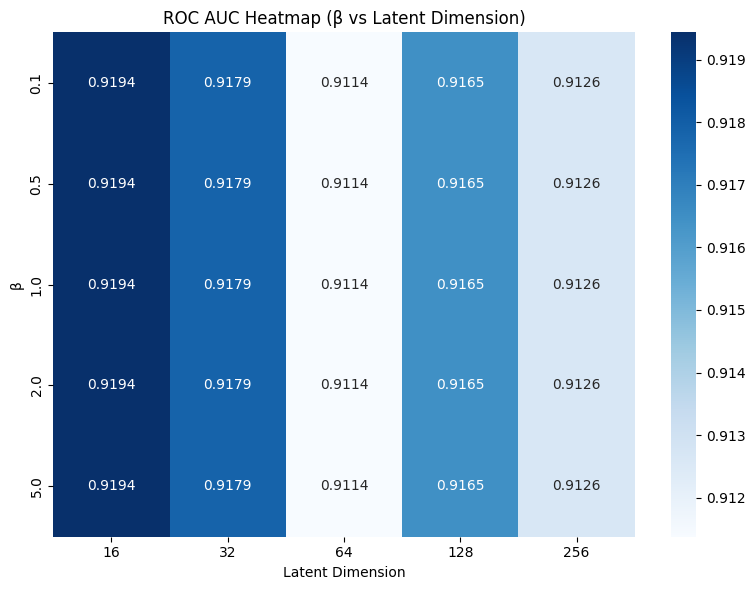

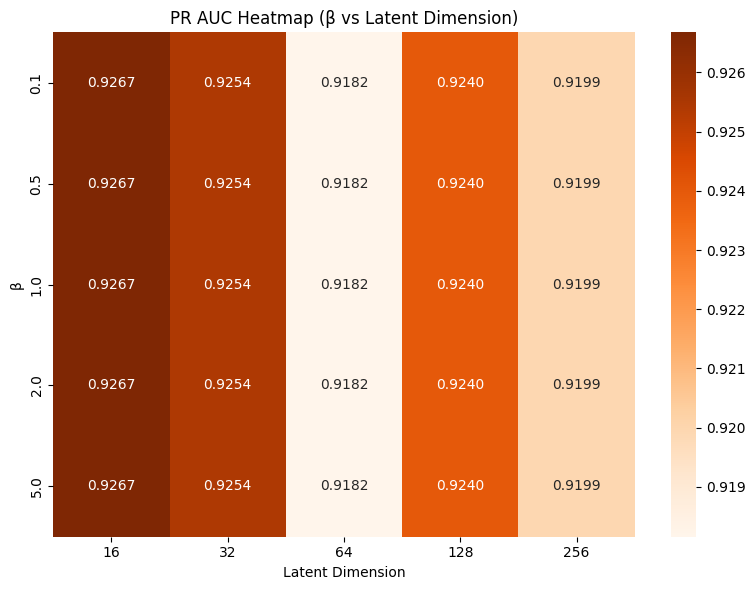

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df_results = pd.DataFrame(results)

# Load results
df =pd.DataFrame(df_results)

# Create pivot tables
pivot_roc = df.pivot(index='beta', columns='latent_dim', values='roc_auc')
pivot_pr = df.pivot(index='beta', columns='latent_dim', values='pr_auc')

# Plot ROC AUC heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_roc, annot=True, fmt=".4f", cmap="Blues")
plt.title("ROC AUC Heatmap (β vs Latent Dimension)")
plt.xlabel("Latent Dimension")
plt.ylabel("β")
plt.tight_layout()
#plt.savefig("heatmap_roc_auc_beta_latentdim.png", dpi=300)
plt.show()

# Plot PR AUC heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_pr, annot=True, fmt=".4f", cmap="Oranges")
plt.title("PR AUC Heatmap (β vs Latent Dimension)")
plt.xlabel("Latent Dimension")
plt.ylabel("β")
plt.tight_layout()
#plt.savefig("heatmap_pr_auc_beta_latentdim.png", dpi=300)
plt.show()


### Custom ß-VAE with pytorch

In [5]:
from vae_models.betaVAE import BetaVAE, train_beta_vae, evaluate_beta_vae
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, average_precision_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = X_train_tensor.shape[1]
beta_vae = BetaVAE(input_dim=input_dim, latent_dim=10, beta=4.0).to(device)
optimizer = torch.optim.Adam(beta_vae.parameters(), lr=1e-3)
train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=64, shuffle=True)

# Train
train_beta_vae(beta_vae, train_loader, optimizer, device=device, epochs=50)

# Evaluate
recon_errors, z_latent = evaluate_beta_vae(beta_vae, X_test_tensor, device=device)
roc_auc = roc_auc_score(y_test, recon_errors)
pr_auc = average_precision_score(y_test, recon_errors)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC : {pr_auc:.4f}")


ModuleNotFoundError: No module named 'vae_models'

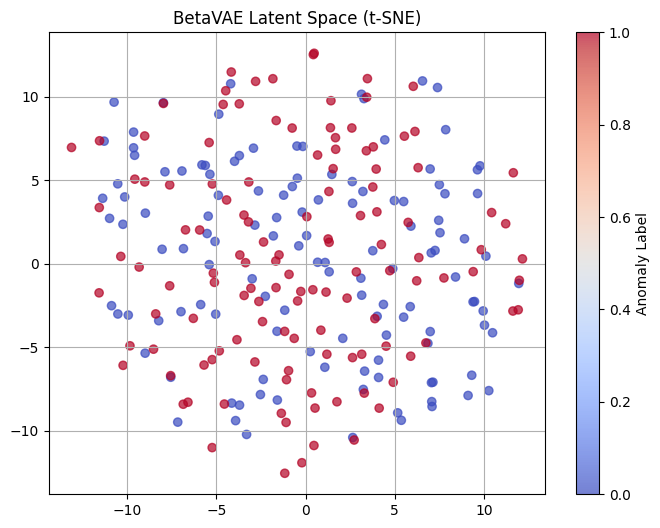

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
z_tsne = tsne.fit_transform(z_latent)

plt.figure(figsize=(8, 6))
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=y_test, cmap='coolwarm', alpha=0.7)
plt.colorbar(label="Anomaly Label")
plt.title("BetaVAE Latent Space (t-SNE)")
plt.grid(True)
plt.show()

In [ ]:
# Define search space
beta_values = [0.1, 0.5, 1.0, 2.0, 5.0]
latent_dims = [16, 32, 64, 128]

results = []
best_roc = 0
best_config = None

for beta in beta_values:
    for latent_dim in latent_dims:
        print(f"\nTraining β-VAE with β={beta}, latent_dim={latent_dim}")

        model = BetaVAE(input_dim=X_train_tensor.shape[1], latent_dim=latent_dim)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=64, shuffle=True)
        train_beta_vae(beta_vae, train_loader, optimizer, device=device, epochs=50)

        recon_errors, z_latent = evaluate_beta_vae(beta_vae, X_test_tensor, device=device)
        roc = roc_auc_score(y_test, recon_errors)
        precision, recall, _ = precision_recall_curve(y_test, recon_errors)
        pr = auc(recall, precision)

        print(f"→ ROC AUC: {roc:.4f}, PR AUC: {pr:.4f}")

        results.append({
            "beta": beta,
            "latent_dim": latent_dim,
            "roc_auc": roc,
            "pr_auc": pr
        })

        if roc > best_roc:
            best_roc = roc
            best_config = {
                "beta": beta,
                "latent_dim": latent_dim,
                "roc_auc": roc,
                "pr_auc": pr
            }

# Show best result
print("\n Best Configuration (based on ROC AUC):")
print(f"β = {best_config['beta']}, latent_dim = {best_config['latent_dim']}")
print(f"ROC AUC = {best_config['roc_auc']:.4f}, PR AUC = {best_config['pr_auc']:.4f}")



Training β-VAE with β=0.1, latent_dim=16
Epoch 1, Loss: 0.13
Epoch 2, Loss: 0.14
Epoch 3, Loss: 0.14
Epoch 4, Loss: 0.13
Epoch 5, Loss: 0.14
Epoch 6, Loss: 0.13
Epoch 7, Loss: 0.13
Epoch 8, Loss: 0.13
Epoch 9, Loss: 0.13
Epoch 10, Loss: 0.14
Epoch 11, Loss: 0.13
Epoch 12, Loss: 0.13
Epoch 13, Loss: 0.14
Epoch 14, Loss: 0.14
Epoch 15, Loss: 0.13
Epoch 16, Loss: 0.15
Epoch 17, Loss: 0.14
Epoch 18, Loss: 0.14
Epoch 19, Loss: 0.14
Epoch 20, Loss: 0.14
Epoch 21, Loss: 0.14
Epoch 22, Loss: 0.13
Epoch 23, Loss: 0.13
Epoch 24, Loss: 0.14
Epoch 25, Loss: 0.14
Epoch 26, Loss: 0.13
Epoch 27, Loss: 0.13
Epoch 28, Loss: 0.14
Epoch 29, Loss: 0.14
Epoch 30, Loss: 0.14
Epoch 31, Loss: 0.14
Epoch 32, Loss: 0.14
Epoch 33, Loss: 0.13
Epoch 34, Loss: 0.14
Epoch 35, Loss: 0.13
Epoch 36, Loss: 0.14
Epoch 37, Loss: 0.13
Epoch 38, Loss: 0.14
Epoch 39, Loss: 0.14
Epoch 40, Loss: 0.13
Epoch 41, Loss: 0.14
Epoch 42, Loss: 0.14
Epoch 43, Loss: 0.13
Epoch 44, Loss: 0.14
Epoch 45, Loss: 0.14
Epoch 46, Loss: 0.15
E

### Sparse VAE


In [ ]:
from svae import SparseVAE, train_sparse_vae, evaluate_sparse_vae


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_train_tensor.shape[1]

sparse_vae = SparseVAE(input_dim=input_dim, latent_dim=10, beta=1.0, l1_lambda=1e-3).to(device)
optimizer = torch.optim.Adam(sparse_vae.parameters(), lr=1e-3)
train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=64, shuffle=True)

# Train
train_sparse_vae(sparse_vae, train_loader, optimizer, device=device, epochs=50)

# Evaluate
recon_errors, z_latent = evaluate_sparse_vae(sparse_vae, X_test_tensor, device=device)
roc_auc = roc_auc_score(y_test, recon_errors)
pr_auc = average_precision_score(y_test, recon_errors)
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC : {pr_auc:.4f}")

Epoch 1/50 - Loss: 0.9900
Epoch 2/50 - Loss: 0.8390
Epoch 3/50 - Loss: 0.7290
Epoch 4/50 - Loss: 0.6221
Epoch 5/50 - Loss: 0.5554
Epoch 6/50 - Loss: 0.4508
Epoch 7/50 - Loss: 0.3601
Epoch 8/50 - Loss: 0.2915
Epoch 9/50 - Loss: 0.2239
Epoch 10/50 - Loss: 0.2264
Epoch 11/50 - Loss: 0.2111
Epoch 12/50 - Loss: 0.1909
Epoch 13/50 - Loss: 0.1878
Epoch 14/50 - Loss: 0.1768
Epoch 15/50 - Loss: 0.1923
Epoch 16/50 - Loss: 0.1659
Epoch 17/50 - Loss: 0.1822
Epoch 18/50 - Loss: 0.1695
Epoch 19/50 - Loss: 0.1547
Epoch 20/50 - Loss: 0.1645
Epoch 21/50 - Loss: 0.1645
Epoch 22/50 - Loss: 0.1668
Epoch 23/50 - Loss: 0.1562
Epoch 24/50 - Loss: 0.1509
Epoch 25/50 - Loss: 0.1411
Epoch 26/50 - Loss: 0.1591
Epoch 27/50 - Loss: 0.1535
Epoch 28/50 - Loss: 0.1519
Epoch 29/50 - Loss: 0.1502
Epoch 30/50 - Loss: 0.1519
Epoch 31/50 - Loss: 0.1497
Epoch 32/50 - Loss: 0.1437
Epoch 33/50 - Loss: 0.1426
Epoch 34/50 - Loss: 0.1586
Epoch 35/50 - Loss: 0.1373
Epoch 36/50 - Loss: 0.1407
Epoch 37/50 - Loss: 0.1370
Epoch 38/5

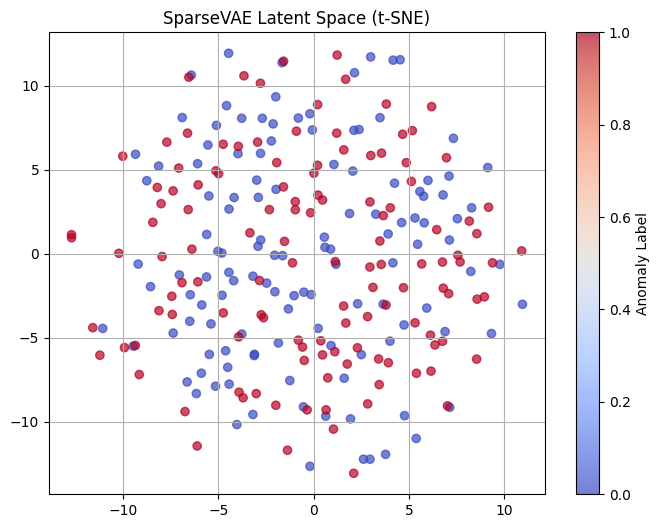

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
z_tsne = tsne.fit_transform(z_latent)

plt.figure(figsize=(8, 6))
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=y_test, cmap='coolwarm', alpha=0.7)
plt.colorbar(label="Anomaly Label")
plt.title("SparseVAE Latent Space (t-SNE)")
plt.grid(True)
plt.show()

#### Hyperparameter tuning


In [ ]:
l1_lambdas = [1e-4, 1e-3, 1e-2]
latent_dims = [16, 32, 64, 128]
beta = 1.0

sparse_results = []
best_auc = 0
best_config = None

for l1_lambda in l1_lambdas:
    for latent_dim in latent_dims:
        print(f"\nTraining SparseVAE with λ={l1_lambda}, latent_dim={latent_dim}")
        model = SparseVAE(input_dim=X_train_tensor.shape[1], latent_dim=latent_dim, l1_lambda=l1_lambda)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=64, shuffle=True)

        train_sparse_vae(sparse_vae, train_loader, optimizer, device=device, epochs=50)
        recon_errors, z_latent = evaluate_sparse_vae(sparse_vae, X_test_tensor, device=device)
        roc_auc = roc_auc_score(y_test, recon_errors)
        precision, recall, _ = precision_recall_curve(y_test, recon_errors)
        pr = auc(recall, precision)
        print(f"→ ROC AUC: {roc:.4f}, PR AUC: {pr:.4f}")

        sparse_results.append({
            "l1_lambda": l1_lambda,
            "latent_dim": latent_dim,
            "roc_auc": roc,
            "pr_auc": pr
        })

        if roc > best_auc:
            best_auc = roc
            best_config = {
                "l1_lambda": l1_lambda,
                "latent_dim": latent_dim,
                "roc_auc": roc,
                "pr_auc": pr,
                "model": model
            }

print("\n Best SparseVAE Configuration (by ROC AUC):")
print(f"λ = {best_config['l1_lambda']}, latent_dim = {best_config['latent_dim']}")
print(f"ROC AUC = {best_config['roc_auc']:.4f}, PR AUC = {best_config['pr_auc']:.4f}")



Training SparseVAE with λ=0.0001, latent_dim=16
Epoch 1/50 - Loss: 0.1387
Epoch 2/50 - Loss: 0.1225
Epoch 3/50 - Loss: 0.1330
Epoch 4/50 - Loss: 0.1493
Epoch 5/50 - Loss: 0.1304
Epoch 6/50 - Loss: 0.1275
Epoch 7/50 - Loss: 0.1363
Epoch 8/50 - Loss: 0.1337
Epoch 9/50 - Loss: 0.1376
Epoch 10/50 - Loss: 0.1311
Epoch 11/50 - Loss: 0.1357
Epoch 12/50 - Loss: 0.1393
Epoch 13/50 - Loss: 0.1402
Epoch 14/50 - Loss: 0.1268
Epoch 15/50 - Loss: 0.1346
Epoch 16/50 - Loss: 0.1453
Epoch 17/50 - Loss: 0.1274
Epoch 18/50 - Loss: 0.1345
Epoch 19/50 - Loss: 0.1391
Epoch 20/50 - Loss: 0.1408
Epoch 21/50 - Loss: 0.1353
Epoch 22/50 - Loss: 0.1313
Epoch 23/50 - Loss: 0.1404
Epoch 24/50 - Loss: 0.1322
Epoch 25/50 - Loss: 0.1522
Epoch 26/50 - Loss: 0.1388
Epoch 27/50 - Loss: 0.1420
Epoch 28/50 - Loss: 0.1369
Epoch 29/50 - Loss: 0.1337
Epoch 30/50 - Loss: 0.1351
Epoch 31/50 - Loss: 0.1340
Epoch 32/50 - Loss: 0.1426
Epoch 33/50 - Loss: 0.1385
Epoch 34/50 - Loss: 0.1394
Epoch 35/50 - Loss: 0.1357
Epoch 36/50 - L

### Factor VAE

In [ ]:
from fvae import FactorVAE, Discriminator, train_factor_vae, evaluate_factor_vae

input_dim = X_train_tensor.shape[1]
latent_dim = 10
beta = 10.0

model = FactorVAE(input_dim, latent_dim)
discriminator = Discriminator(latent_dim)

optimizer_vae = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001)

train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=64, shuffle=True)

train_factor_vae(model, discriminator, train_loader, optimizer_vae, optimizer_disc, beta=beta, epochs=50)


In [ ]:
recon_errors = evaluate_factor_vae(model, X_test_tensor)

roc = roc_auc_score(y_test, recon_errors)
precision, recall, _ = precision_recall_curve(y_test, recon_errors)
pr = auc(recall, precision)

print(f"\nFactorVAE → ROC AUC: {roc:.4f}, PR AUC: {pr:.4f}")



FactorVAE → ROC AUC: 0.8710, PR AUC: 0.8846


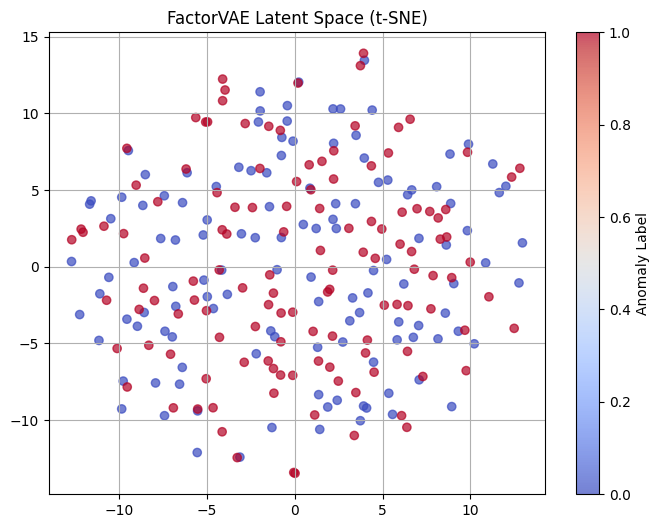

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
z_tsne = tsne.fit_transform(z_latent)

plt.figure(figsize=(8, 6))
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=y_test, cmap='coolwarm', alpha=0.7)
plt.colorbar(label="Anomaly Label")
plt.title("FactorVAE Latent Space (t-SNE)")
plt.grid(True)
plt.show()

#### Hyperparameter tuning


In [ ]:
latent_dims = [8, 16, 32, 64]
beta_values = [1.0, 5.0, 10.0]
epochs = 100
batch_size = 64

# Data
input_dim = X_train_tensor.shape[1]
train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)
X_test_tensor = X_test_tensor

results = []
best_roc = 0
best_config = None

for latent_dim in latent_dims:
    for beta in beta_values:
        print(f"\nTraining FactorVAE (latent_dim={latent_dim}, beta={beta})")

        # Init models
        model = FactorVAE(input_dim=input_dim, latent_dim=latent_dim)
        discriminator = Discriminator(latent_dim=latent_dim)

        optimizer_vae = torch.optim.Adam(model.parameters(), lr=0.001)
        optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001)

        # Train
        train_factor_vae(model, discriminator, train_loader, optimizer_vae, optimizer_disc, beta=beta, epochs=epochs)

        # Evaluate
        recon_errors = evaluate_factor_vae(model, X_test_tensor)
        roc = roc_auc_score(y_test, recon_errors)
        precision, recall, _ = precision_recall_curve(y_test, recon_errors)
        pr = auc(recall, precision)

        print(f"→ ROC AUC: {roc:.4f}, PR AUC: {pr:.4f}")

        results.append({
            "latent_dim": latent_dim,
            "beta": beta,
            "roc_auc": roc,
            "pr_auc": pr
        })

        if roc > best_roc:
            best_roc = roc
            best_config = {
                "latent_dim": latent_dim,
                "beta": beta,
                "roc_auc": roc,
                "pr_auc": pr
            }

# --- Final Result ---
print("\n Best Configuration (based on ROC AUC):")
print(f"latent_dim = {best_config['latent_dim']}, beta = {best_config['beta']}")
print(f"ROC AUC = {best_config['roc_auc']:.4f}, PR AUC = {best_config['pr_auc']:.4f}")


Training FactorVAE (latent_dim=8, beta=1.0)
→ ROC AUC: 0.8741, PR AUC: 0.8892

Training FactorVAE (latent_dim=8, beta=5.0)
→ ROC AUC: 0.8787, PR AUC: 0.8962

Training FactorVAE (latent_dim=8, beta=10.0)
→ ROC AUC: 0.8696, PR AUC: 0.8777

Training FactorVAE (latent_dim=16, beta=1.0)
→ ROC AUC: 0.8705, PR AUC: 0.8848

Training FactorVAE (latent_dim=16, beta=5.0)
→ ROC AUC: 0.8704, PR AUC: 0.8821

Training FactorVAE (latent_dim=16, beta=10.0)
→ ROC AUC: 0.8750, PR AUC: 0.8904

Training FactorVAE (latent_dim=32, beta=1.0)
→ ROC AUC: 0.8505, PR AUC: 0.8650

Training FactorVAE (latent_dim=32, beta=5.0)
→ ROC AUC: 0.8702, PR AUC: 0.8835

Training FactorVAE (latent_dim=32, beta=10.0)
→ ROC AUC: 0.8672, PR AUC: 0.8848

Training FactorVAE (latent_dim=64, beta=1.0)
→ ROC AUC: 0.8653, PR AUC: 0.8673

Training FactorVAE (latent_dim=64, beta=5.0)
→ ROC AUC: 0.8528, PR AUC: 0.8669

Training FactorVAE (latent_dim=64, beta=10.0)
→ ROC AUC: 0.8605, PR AUC: 0.8793

 Best Configuration (based on ROC AUC)

### ß-TCVAE

In [ ]:
from betatcvae import BetaTCVAE, TCVDiscriminator, train_tcvae, evaluate_tcvae

input_dim = X_train_tensor.shape[1]
latent_dim = 16
model = BetaTCVAE(input_dim=input_dim, latent_dim=latent_dim)
discriminator = TCVDiscriminator(latent_dim=latent_dim)

opt_vae = torch.optim.Adam(model.parameters(), lr=1e-3)
opt_disc = torch.optim.Adam(discriminator.parameters(), lr=1e-3)

train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=64, shuffle=True)

train_tcvae(model, discriminator, train_loader, opt_vae, opt_disc, beta=6.0, epochs=50)

errors = evaluate_tcvae(model, X_test_tensor)
roc = roc_auc_score(y_test, errors)
precision, recall, _ = precision_recall_curve(y_test, errors)
pr = auc(recall, precision)

print(f"Beta-TCVAE ROC AUC: {roc:.4f}, PR AUC: {pr:.4f}")


Beta-TCVAE ROC AUC: 0.8565, PR AUC: 0.8731


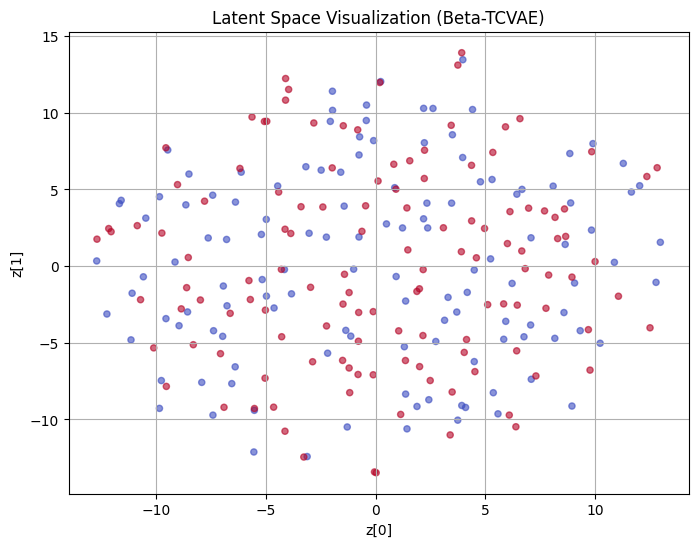

In [ ]:
tsne = TSNE(n_components=2, perplexity=30)
z_embedded = tsne.fit_transform(z_latent)

plt.figure(figsize=(8, 6))
plt.scatter(z_embedded[:, 0], z_embedded[:, 1], c=y_test, cmap="coolwarm", s=20, alpha=0.6)
plt.title("Latent Space Visualization (Beta-TCVAE)")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.grid(True)
plt.show()


In [ ]:
latent_dims = [8, 16, 32, 64]
beta_values = [1.0, 5.0, 10.0]
epochs = 100
batch_size = 64

# Data
input_dim = X_train_tensor.shape[1]
train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)

results = []
best_roc = 0
best_config = None

for latent_dim in latent_dims:
    for beta in beta_values:
        print(f"\nTraining Beta-TCVAE (latent_dim={latent_dim}, beta={beta})")

        # Init model
        model = BetaTCVAE(input_dim=input_dim, latent_dim=latent_dim)
        discriminator = TCVDiscriminator(latent_dim=latent_dim)

        optimizer_vae = torch.optim.Adam(model.parameters(), lr=0.001)
        optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001)
        train_tcvae(model, discriminator, train_loader, optimizer_vae, optimizer_disc, beta=beta, epochs=epochs)


        # Evaluate
        recon_errors = evaluate_tcvae(model, X_test_tensor)

        roc = roc_auc_score(y_test, recon_errors)
        precision, recall, _ = precision_recall_curve(y_test, recon_errors)
        pr = auc(recall, precision)

        print(f"→ ROC AUC: {roc:.4f}, PR AUC: {pr:.4f}")

        results.append({
            "latent_dim": latent_dim,
            "beta": beta,
            "roc_auc": roc,
            "pr_auc": pr
        })

        if roc > best_roc:
            best_roc = roc
            best_config = {
                "latent_dim": latent_dim,
                "beta": beta,
                "roc_auc": roc,
                "pr_auc": pr
            }

# --- Final Result ---
print("\n Best Beta-TCVAE Configuration (based on ROC AUC):")
print(f"latent_dim = {best_config['latent_dim']}, beta = {best_config['beta']}")
print(f"ROC AUC = {best_config['roc_auc']:.4f}, PR AUC = {best_config['pr_auc']:.4f}")


Training Beta-TCVAE (latent_dim=8, beta=1.0)
→ ROC AUC: 0.8941, PR AUC: 0.9087

Training Beta-TCVAE (latent_dim=8, beta=5.0)
→ ROC AUC: 0.8789, PR AUC: 0.8959

Training Beta-TCVAE (latent_dim=8, beta=10.0)
→ ROC AUC: 0.8806, PR AUC: 0.8957

Training Beta-TCVAE (latent_dim=16, beta=1.0)
→ ROC AUC: 0.8653, PR AUC: 0.8773

Training Beta-TCVAE (latent_dim=16, beta=5.0)
→ ROC AUC: 0.8656, PR AUC: 0.8773

Training Beta-TCVAE (latent_dim=16, beta=10.0)
→ ROC AUC: 0.8587, PR AUC: 0.8619

Training Beta-TCVAE (latent_dim=32, beta=1.0)
→ ROC AUC: 0.8633, PR AUC: 0.8769

Training Beta-TCVAE (latent_dim=32, beta=5.0)
→ ROC AUC: 0.8612, PR AUC: 0.8727

Training Beta-TCVAE (latent_dim=32, beta=10.0)
→ ROC AUC: 0.8668, PR AUC: 0.8735

Training Beta-TCVAE (latent_dim=64, beta=1.0)
→ ROC AUC: 0.8545, PR AUC: 0.8662

Training Beta-TCVAE (latent_dim=64, beta=5.0)
→ ROC AUC: 0.8541, PR AUC: 0.8690

Training Beta-TCVAE (latent_dim=64, beta=10.0)
→ ROC AUC: 0.8610, PR AUC: 0.8749

 Best Beta-TCVAE Configura

In [ ]:
from cvae import ConditionalVAE, train_conditional_vae, evaluate_conditional_vae

In [ ]:
# Setup
y_train = np.zeros(len(x_train))
Y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
Y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=64, shuffle=True)

input_dim = X_train_tensor.shape[1]
cond_dim = 1
cvae = ConditionalVAE(input_dim=input_dim, latent_dim=10, cond_dim=cond_dim).to(device)
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)

# Train
train_conditional_vae(cvae, train_loader, optimizer, device=device, epochs=50)

# Evaluate
recon_errors, z_latent = evaluate_conditional_vae(cvae, X_test_tensor, Y_test_tensor, device=device)
roc_auc = roc_auc_score(y_test, recon_errors)
pr_auc = average_precision_score(y_test, recon_errors)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC : {pr_auc:.4f}")


[CVAE] Epoch 1/50 - Loss: 0.9771
[CVAE] Epoch 2/50 - Loss: 0.8507
[CVAE] Epoch 3/50 - Loss: 0.7492
[CVAE] Epoch 4/50 - Loss: 0.6396
[CVAE] Epoch 5/50 - Loss: 0.5825
[CVAE] Epoch 6/50 - Loss: 0.5012
[CVAE] Epoch 7/50 - Loss: 0.4086
[CVAE] Epoch 8/50 - Loss: 0.3195
[CVAE] Epoch 9/50 - Loss: 0.2630
[CVAE] Epoch 10/50 - Loss: 0.2260
[CVAE] Epoch 11/50 - Loss: 0.1952
[CVAE] Epoch 12/50 - Loss: 0.1868
[CVAE] Epoch 13/50 - Loss: 0.2014
[CVAE] Epoch 14/50 - Loss: 0.1877
[CVAE] Epoch 15/50 - Loss: 0.1795
[CVAE] Epoch 16/50 - Loss: 0.1691
[CVAE] Epoch 17/50 - Loss: 0.1734
[CVAE] Epoch 18/50 - Loss: 0.1747
[CVAE] Epoch 19/50 - Loss: 0.1674
[CVAE] Epoch 20/50 - Loss: 0.1550
[CVAE] Epoch 21/50 - Loss: 0.1684
[CVAE] Epoch 22/50 - Loss: 0.1700
[CVAE] Epoch 23/50 - Loss: 0.1670
[CVAE] Epoch 24/50 - Loss: 0.1652
[CVAE] Epoch 25/50 - Loss: 0.1574
[CVAE] Epoch 26/50 - Loss: 0.1493
[CVAE] Epoch 27/50 - Loss: 0.1616
[CVAE] Epoch 28/50 - Loss: 0.1511
[CVAE] Epoch 29/50 - Loss: 0.1497
[CVAE] Epoch 30/50 - Lo

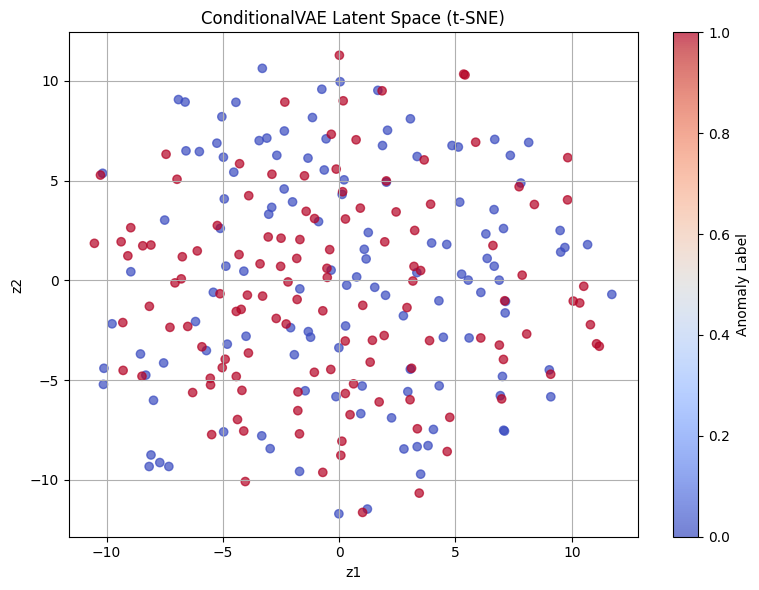

In [ ]:
z_tsne = TSNE(n_components=2, random_state=42).fit_transform(z_latent)

plt.figure(figsize=(8, 6))
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=y_test, cmap='coolwarm', alpha=0.7)
plt.colorbar(label="Anomaly Label")
plt.title("ConditionalVAE Latent Space (t-SNE)")
plt.xlabel("z1")
plt.ylabel("z2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from itertools import product

latent_dims = [5, 10, 20]
learning_rates = [1e-3, 5e-4]
batch_sizes = [32, 64]
betas = [1.0, 4.0]

param_grid = list(product(latent_dims, learning_rates, batch_sizes, betas))
best_config = None
best_roc_auc = -1

for latent_dim, lr, batch_size, beta in param_grid:
    print(f"Trying config: latent_dim={latent_dim}, lr={lr}, batch_size={batch_size}, beta={beta}")

    # Re-initialize model and optimizer
    model = ConditionalVAE(input_dim=X_train_tensor.shape[1], latent_dim=latent_dim, cond_dim=1)
    model.beta = beta  # If you're using beta inside loss_function
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Create dataloader for this batch size
    y_train = np.zeros(len(x_train))
    Y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
    train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)

    # Train for fewer epochs (quick tuning)
    train_conditional_vae(model, train_loader, optimizer, device=device, epochs=10)

    # Evaluate on test set
    Y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)
    recon_errors, _ = evaluate_conditional_vae(model, X_test_tensor, Y_test_tensor, device=device)
    roc_auc = roc_auc_score(y_test, recon_errors)
    pr_auc = average_precision_score(y_test, recon_errors)

    print(f"ROC AUC: {roc_auc:.4f} | PR AUC: {pr_auc:.4f}")

    # Keep best
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_config = (latent_dim, lr, batch_size, beta)

print("\nBest Config:")
print(f"latent_dim={best_config[0]}, lr={best_config[1]}, batch_size={best_config[2]}, beta={best_config[3]}")
print(f"Best ROC AUC: {best_roc_auc:.4f}")



Trying config: latent_dim=5, lr=0.001, batch_size=32, beta=1.0
[CVAE] Epoch 1/10 - Loss: 1.6586
[CVAE] Epoch 2/10 - Loss: 1.4091
[CVAE] Epoch 3/10 - Loss: 0.9333
[CVAE] Epoch 4/10 - Loss: 0.7337
[CVAE] Epoch 5/10 - Loss: 0.5463
[CVAE] Epoch 6/10 - Loss: 0.4348
[CVAE] Epoch 7/10 - Loss: 0.3903
[CVAE] Epoch 8/10 - Loss: 0.3592
[CVAE] Epoch 9/10 - Loss: 0.3927
[CVAE] Epoch 10/10 - Loss: 0.4928
ROC AUC: 0.8352 | PR AUC: 0.8547
Trying config: latent_dim=5, lr=0.001, batch_size=32, beta=4.0
[CVAE] Epoch 1/10 - Loss: 1.6498
[CVAE] Epoch 2/10 - Loss: 1.1570
[CVAE] Epoch 3/10 - Loss: 0.8388
[CVAE] Epoch 4/10 - Loss: 0.5716
[CVAE] Epoch 5/10 - Loss: 0.4038
[CVAE] Epoch 6/10 - Loss: 0.3601
[CVAE] Epoch 7/10 - Loss: 0.4055
[CVAE] Epoch 8/10 - Loss: 0.3110
[CVAE] Epoch 9/10 - Loss: 0.2996
[CVAE] Epoch 10/10 - Loss: 0.2995
ROC AUC: 0.8640 | PR AUC: 0.8627
Trying config: latent_dim=5, lr=0.001, batch_size=64, beta=1.0
[CVAE] Epoch 1/10 - Loss: 0.8855
[CVAE] Epoch 2/10 - Loss: 0.7653
[CVAE] Epoch 3/10